In [1]:
import sys
path_to_pip_installs = "/tmp/test_env"
if path_to_pip_installs not in sys.path:
    sys.path.insert(0, path_to_pip_installs)

In [2]:
import argparse
import itk
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from src.diffusion_registration.training.config import Config
from src.diffusion_registration.core.models import DiffusionRegistrationNet
from src.diffusion_registration.core.wrappers import register_pair
from src.diffusion_registration.data.own_loaders import create_data_loaders
from src.diffusion_registration.core.wrappers import compute_warped_image_multiNC

import monai
from monai.metrics import DiceMetric
dice_metric = DiceMetric(include_background=True, reduction="mean")
LNCC_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(spatial_dims=2)
MI_loss = monai.losses.GlobalMutualInformationLoss()
SSIM_loss = monai.losses.ssim_loss.SSIMLoss(spatial_dims=2)

2025-10-30 10:50:04.360071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def tensor_to_itk(tensor: torch.Tensor) -> itk.Image:
    """Converts a (C, H, W) or (H, W) tensor to an itk.Image."""
    
    # Remove batch dim if present
    if tensor.dim() == 4:
        tensor = tensor.squeeze(0)
    # Remove channel dim
    if tensor.dim() == 3:
        tensor = tensor.squeeze(0)
    
    # Move to CPU and convert to numpy
    img_np = tensor.detach().cpu().numpy().astype(np.float32)
    
    # Convert to itk image
    # Note: This creates a basic itk.Image. It won't have the
    # spacing or origin info of the original pre-processed file.
    itk_image = itk.image_from_array(img_np)
    itk_image.SetSpacing([1.0] * itk_image.GetImageDimension())
    
    return itk_image

In [4]:
device = "cpu"
config = Config("config/config_2d_lncc.yaml")
config.training.device = device

net = DiffusionRegistrationNet(config)
    
checkpoint_path = "checkpoints/lncc/final_model.pth"
#checkpoint_path = "/home/students/studweilc1/dgir/checkpoints/checkpoint_epoch_1000.pth"
net.load_checkpoint(checkpoint_path)

net.to(device)
net.eval()

In [5]:
train_dataset, test_dataset, train_masks_dataset, test_masks_dataset = create_data_loaders(config, with_masks=True)
dataset = test_dataset
dataset_masks = test_masks_dataset

Loading training data...
Loading validation data...
Normalizing images...
Training set A shape: torch.Size([950, 1, 256, 256])
Training set B shape: torch.Size([950, 1, 256, 256])
Validation set A shape: torch.Size([102, 1, 256, 256])
Validation set B shape: torch.Size([102, 1, 256, 256])


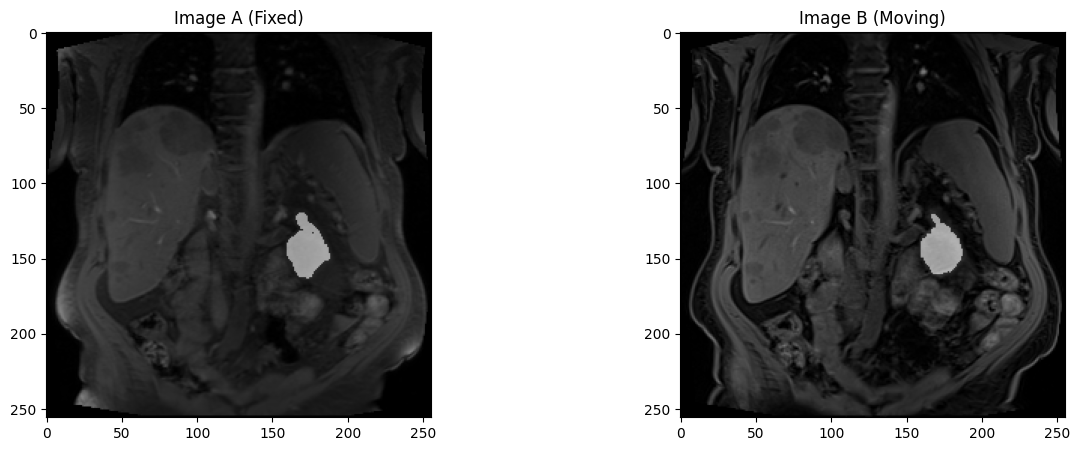

In [6]:
index = 0
image_A_tensor, image_B_tensor = dataset[index]
image_A_batch = image_A_tensor.unsqueeze(0).to(device)
image_B_batch = image_B_tensor.unsqueeze(0).to(device)
mask_A_tensor, mask_B_tensor = dataset_masks[index]
mask_A_batch = mask_A_tensor.unsqueeze(0).to(device)
mask_B_batch = mask_B_tensor.unsqueeze(0).to(device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image_A_tensor.squeeze().cpu(), cmap='gray')
ax[0].imshow(mask_A_tensor.squeeze().cpu(), cmap='gray', alpha=0.5)
ax[0].set_title("Image A (Fixed)")
ax[1].imshow(image_B_tensor.squeeze().cpu(), cmap='gray')
ax[1].imshow(mask_B_tensor.squeeze().cpu(), cmap='gray', alpha=0.5)
ax[1].set_title("Image B (Moving)")
plt.show()

In [7]:
with torch.no_grad():
        # The forward pass of the network (e.g., BendingEnergyNet) calculates
        # the loss and also stores the results (phi_AB_vectorfield, warped_image_A)
        # as attributes of the 'net.net' object.
        #
        loss_object = net(image_A_batch, image_B_batch)

In [8]:
transform_map = net.net.phi_AB_vectorfield
spacing = net.net.spacing
warped_A_batch = net.net.warped_image_A
print(f"Registration complete. Loss: {loss_object.all_loss.item():.4f}")

with torch.no_grad():
        # Warp the mask using Nearest Neighbor (spline_order=0)
        #
        warped_mask_A_batch = compute_warped_image_multiNC(
            mask_A_tensor.unsqueeze(0),  # Input must be float for grid_sample
            transform_map,
            spacing,
            spline_order=0
        ).round()

Registration complete. Loss: 0.3559


0.4777255058288574
0.47516435384750366
-0.3683912456035614
-0.3815220594406128
Dice Coefficient before registration: 0.92759562
Dice Coefficient after registration: 0.91455913


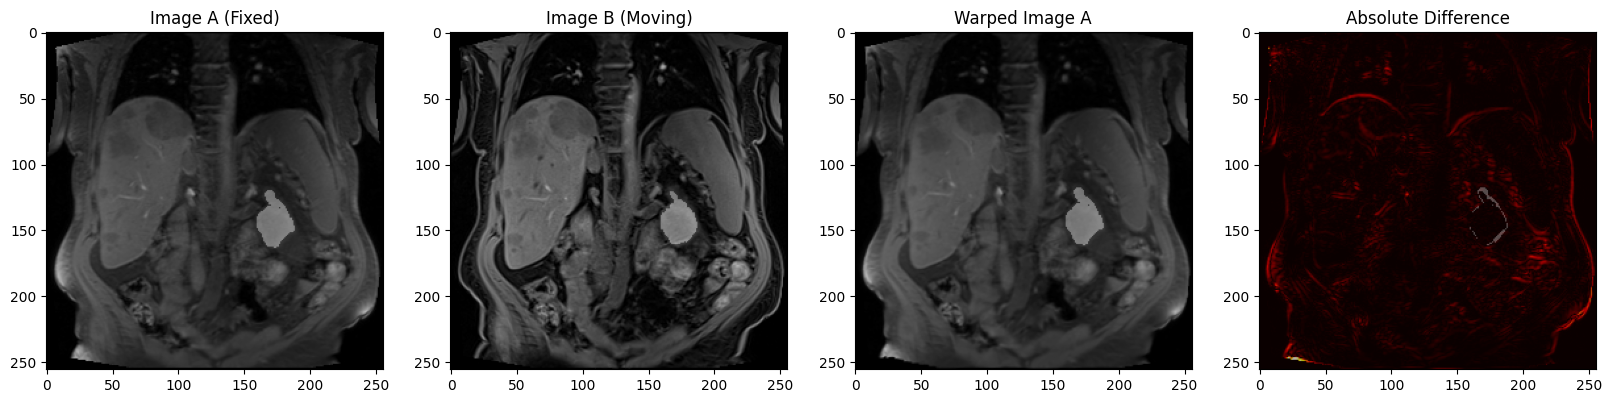

In [9]:
dce_before = dice_metric(
    y_pred=mask_A_batch.float(),
    y=mask_B_batch.float()
).item()

dce_after = dice_metric(
    y_pred=warped_mask_A_batch.float(),
    y=mask_B_batch.float()
).item()

print(SSIM_loss(image_A_batch, image_B_batch).item())
print(SSIM_loss(warped_A_batch, image_B_batch).item())
print(LNCC_loss(image_A_batch, image_B_batch).item())
print(LNCC_loss(warped_A_batch, image_B_batch).item())

print(f"Dice Coefficient before registration: {dce_before:.8f}")
print(f"Dice Coefficient after registration: {dce_after:.8f}")

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image_A_tensor.squeeze().cpu(), cmap='gray')
ax[0].imshow(mask_A_tensor.squeeze().cpu(), cmap='gray', alpha=0.3)
ax[0].set_title("Image A (Fixed)")
ax[1].imshow(image_B_tensor.squeeze().cpu(), cmap='gray')
ax[1].imshow(mask_B_tensor.squeeze().cpu(), cmap='gray', alpha=0.3)
ax[1].set_title("Image B (Moving)")
ax[2].imshow(warped_A_batch.squeeze().cpu().squeeze(), cmap='gray')
ax[2].imshow(warped_mask_A_batch.squeeze().cpu(), cmap='gray', alpha=0.3)
ax[2].set_title("Warped Image A")
ax[3].imshow(torch.abs(warped_A_batch - image_A_tensor).squeeze().cpu(), cmap='hot')
ax[3].imshow(torch.abs(warped_mask_A_batch - mask_B_tensor).squeeze().cpu(), cmap='hot', alpha=0.3)
ax[3].set_title("Absolute Difference")
plt.show()

## Full Loop

In [12]:
dce_befores = []
dce_afters = []
ssim_befores = []
ssim_afters = []
lncc_befores = []
lncc_afters = []

for index in range(10): #range(len(dataset)):
    image_A_tensor, image_B_tensor = dataset[index]
    image_A_batch = image_A_tensor.unsqueeze(0).to(device)
    image_B_batch = image_B_tensor.unsqueeze(0).to(device)
    mask_A_tensor, mask_B_tensor = dataset_masks[index]
    mask_A_batch = mask_A_tensor.unsqueeze(0).to(device)
    mask_B_batch = mask_B_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
            # The forward pass of the network (e.g., BendingEnergyNet) calculates
            # the loss and also stores the results (phi_AB_vectorfield, warped_image_A)
            # as attributes of the 'net.net' object.
            #
            loss_object = net(image_A_batch, image_B_batch)

    transform_map = net.net.phi_AB_vectorfield
    spacing = net.net.spacing
    warped_A_batch = net.net.warped_image_A
    print(f"Registration complete. Loss: {loss_object.all_loss.item():.4f}")

    with torch.no_grad():
            # Warp the mask using Nearest Neighbor (spline_order=0)
            #
            warped_mask_A_batch = compute_warped_image_multiNC(
                mask_A_tensor.unsqueeze(0),  # Input must be float for grid_sample
                transform_map,
                spacing,
                spline_order=0
            ).round()

    dce_before = dice_metric(
        y_pred=mask_B_batch.float(),
        y=mask_A_batch.float()
    ).item()

    dce_after = dice_metric(
        y_pred=warped_mask_A_batch.float(),
        y=mask_B_batch.float()
    ).item()
    dce_befores.append(dce_before)
    dce_afters.append(dce_after)

    ssim_before = SSIM_loss(image_A_batch, image_B_batch).item()
    ssim_after = SSIM_loss(warped_A_batch, image_B_batch).item()
    ssim_befores.append(ssim_before)
    ssim_afters.append(ssim_after)

    lncc_before = LNCC_loss(image_A_batch, image_B_batch).item()
    lncc_after = LNCC_loss(warped_A_batch, image_B_batch).item()
    lncc_befores.append(lncc_before)
    lncc_afters.append(lncc_after)

    print(f"Dice Coefficient before registration: {dce_before:.4f}")
    print(f"Dice Coefficient after registration: {dce_after:.4f}")

Registration complete. Loss: 0.3559
Dice Coefficient before registration: 0.9276
Dice Coefficient after registration: 0.9146
Registration complete. Loss: 0.3333
Dice Coefficient before registration: 0.9403
Dice Coefficient after registration: 0.8999
Registration complete. Loss: 0.3516
Dice Coefficient before registration: 0.8169
Dice Coefficient after registration: 0.8428
Registration complete. Loss: 0.3627
Dice Coefficient before registration: 0.8183
Dice Coefficient after registration: 0.8503
Registration complete. Loss: 0.3425
Dice Coefficient before registration: 0.8591
Dice Coefficient after registration: 0.8670
Registration complete. Loss: 0.3502
Dice Coefficient before registration: 0.8493
Dice Coefficient after registration: 0.8754
Registration complete. Loss: 0.3748
Dice Coefficient before registration: 0.8543
Dice Coefficient after registration: 0.7965
Registration complete. Loss: 0.4102
Dice Coefficient before registration: 0.8651
Dice Coefficient after registration: 0.8183


In [13]:
np.mean(dce_befores), np.mean(dce_afters), np.mean(ssim_befores), np.mean(ssim_afters), np.mean(lncc_befores), np.mean(lncc_afters)

(np.float64(0.871876698732376),
 np.float64(0.8586261928081512),
 np.float64(0.49199767112731935),
 np.float64(0.48727813363075256),
 np.float64(-0.3620790809392929),
 np.float64(-0.3778303533792496))